In [1]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import adapt.ml.lda as dlda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp
import tensorflow as tf
import pickle
from datetime import datetime
import time

set_gpu()
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 128
load_mod = False
mod_tot = ['blda','lda','crlda','alda','bcnn','cnn', 'crcnn','acnn03','acnn30','acewc00','acewc30', 'adcnn30', 'vcnn', 'bvcnn', 'avcnn03', 'avcnn15', 'acnnl03','crvcnn','acewclm','xtra','xtra1','xtra2']
ft = 'feat'
iter = 1

for sub in range(4,5):
    print(subs[sub])
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))

    # first iteration, includes LDA; others exclude LDA
    mod_all = ['vcnn']

    # load or initialize cnn weights
    if load_mod:
        with open(subs[sub] + '_' + str(0) + '_r_accs.p','rb') as f:
            all_acc, all_recal, all_val, all_prev, all_train, all_times, _, _, c_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
        all_times = np.zeros((len(all_files),len(mod_tot)))
    else:
        c_weights = None
        v_weights = None
        v_wc = None
        cl_wc = None
        all_recal = np.empty((len(mod_tot),1))
        all_recal[:] = np.nan
        all_acc = np.zeros((len(all_files),len(mod_tot)))
        all_val = np.zeros((len(all_files),len(mod_tot)))
        all_prev = np.zeros((len(all_files),len(mod_tot)))
        all_train = np.zeros((len(all_files),len(mod_tot)))
        all_times = np.zeros((len(all_files),len(mod_tot)))

    mod_i = 0
    for mod in mod_all:
        acc = np.zeros((len(all_files),5))
        acc_val = np.zeros((len(all_files),5))
        acc_prev = np.zeros((len(all_files),5))
        acc_train = np.zeros((len(all_files),5))

        if 'cnn' in mod:
            acc_i = 2
        elif 'cewc' in mod:
            acc_i = 4
        elif 'lda' in mod:
            acc_i = 0

        cnn = None
        ewc = None

        ep = 50
        recal = 0
        skip = False

        # Loop through files
        for i in range(1,2):#len(all_files)-1):
            # load training file
            train_file = all_files[i]
            train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')

            train_data, train_params, th = prd.threshold(train_data, train_params)
            val_data = train_data
            val_params = train_params

            train_dof = np.unique(train_params[:,-1])
            key = np.empty(train_dof.shape)
            for key_i in range(len(train_dof)):
                key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
            n_dof = int(np.max(key))
            
            train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
            val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key)

            _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False,num_classes=n_dof)

            _, _, _, _, x_val_cnn, y_val, x_val_lda, y_val_lda, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)

            del train_data, train_params, val_data, val_params

            cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['vcnn'], n_dof=n_dof, ep=30, dec=False)
            cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_clean_cnn,y_train=y_clean, mod=[cnn], n_dof=n_dof, ep=ep, dec=True)

TR62
training nn
Epoch 1,  Loss: 0.89,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 69.09 
Epoch 2,  Loss: 0.51,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 81.36 
Epoch 3,  Loss: 0.40,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 84.65 
Epoch 4,  Loss: 0.34,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 87.08 
Epoch 5,  Loss: 0.30,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 88.38 
Epoch 6,  Loss: 0.27,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 89.73 
Epoch 7,  Loss: 0.25,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 90.38 
Epoch 8,  Loss: 0.22,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 91.46 
Epoch 9,  Loss: 0.21,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 91.98 
Epoch 10,  Loss: 0.18,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 93.35 
Epoch 11,  Loss: 0.17,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 93.85 
Epoch 12,  Loss: 0.16,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy: 94.24 
Epoch 13,  Loss: 0.14,  Second Loss: 0.00,  KL Loss: 0.00,  Accuracy

In [5]:
samp = np.ones((y_clean.shape[0],4))
x_out,_,_ = cnn.dec(samp,np.argmax(y_clean,axis=1).astype('float32'),samp=True)
x_out = x_out.numpy()

In [4]:
x_out, y_out = cnn(x_clean_cnn,np.argmax(y_clean,axis=1).astype('float32'))
x_out = x_out.numpy()

ValueError: not enough values to unpack (expected 2, got 1)

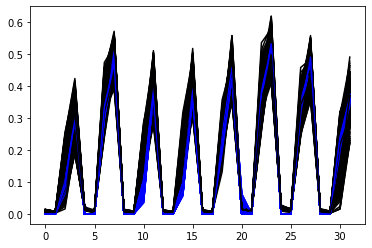

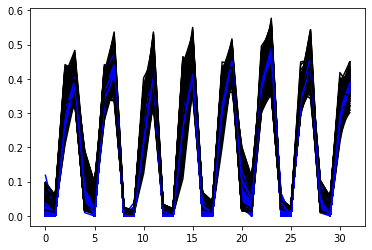

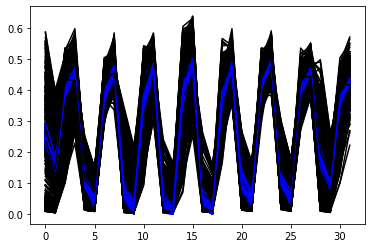

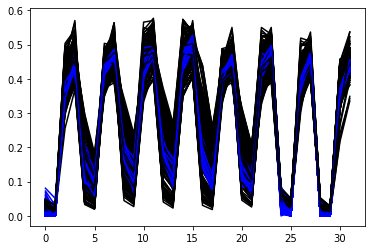

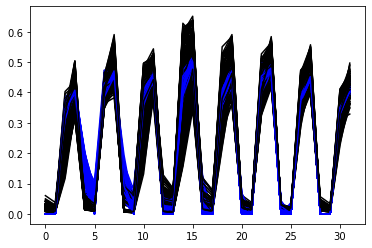

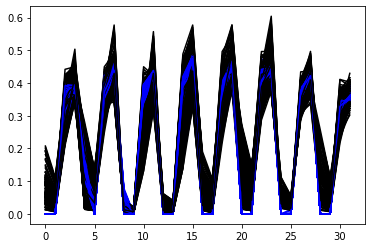

In [6]:
# plt.plot(x_clean_cnn[0,...].reshape(-1))
col = ['k-','b-','r-','g-','c-','m-']
for cl in range(y_clean.shape[1]):
    ind = np.argmax(y_clean,axis=1)==cl
    ind2 = np.argmax(y_clean,axis=1)==cl
    x_temp = x_out[ind,...].reshape((np.sum(ind),-1))
    x_true = x_clean_cnn[ind2,...].reshape((np.sum(ind2),-1))
    # for i in range()
    plt.figure()
    for i in range(x_temp.shape[0]):
        # plt.plot(np.mean(x_temp,axis=0),col[cl])
        plt.plot(x_temp[i,...],'b-')
        plt.plot(x_true[i,...],'k-')

In [7]:
x_lda = x_clean_cnn.reshape(x_clean_cnn.shape[0],-1)
y_lda = np.argmax(y_clean,axis=1)[...,np.newaxis]

In [8]:
w,c, _, _, _, _, _ = dlda.train_lda(x_lda,y_lda)
y_out = dlda.predict(x_lda, w, c)

In [9]:
dlda.eval_lda(w, c, x_lda, y_lda)

0.8542425819885476

In [10]:
x_out_lda = x_out.reshape(x_out.shape[0],-1)
dlda.eval_lda(w,c, x_out_lda,y_lda)

0.5361790733992712

In [11]:
w,c, _, _, _, _, _ = dlda.train_lda(x_out_lda,y_lda)

In [12]:
dlda.eval_lda(w, c, x_out.reshape(x_out.shape[0],-1), np.argmax(y_clean,axis=1)[...,np.newaxis])

1.0

In [13]:
dlda.eval_lda(w, c, x_lda, np.argmax(y_clean,axis=1)[...,np.newaxis])

0.6861009890681936

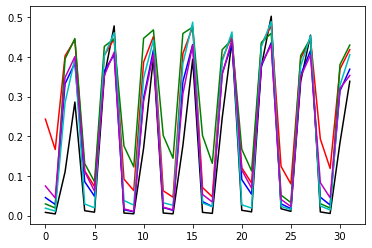

In [10]:
for cl in range(y_clean.shape[1]):
    ind = np.argmax(y_clean,axis=1)==cl
    x_temp = x_out[ind,...].reshape((np.sum(ind),-1))
    x_true = x_clean_cnn[ind,...].reshape((np.sum(ind),-1))
    # for i in range()
    # plt.figure()
    # for i in range(x_temp.shape[0]):
    # plt.plot(np.mean(x_temp,axis=0),col[cl])
    plt.plot(np.mean(x_true,axis=0),col)

In [2]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
if 'skip' in subs:
    subs = np.delete(subs,subs.index('skip'))
bat = 128
load_mod = False
mod_tot = ['blda','lda','crlda','alda','bcnn','cnn', 'crcnn','acnn03','acnn30','acewc00','acewc30', 'adcnn30', 'vcnn', 'bvcnn', 'avcnn03', 'avcnn15', 'acnnl03','crvcnn','acewclm','xtra','xtra1','xtra2']
ft = 'feat'
iter = 1

for sub in range(4,5):
    print(subs[sub])
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))

    for it in range(0,iter):
        # first iteration, includes LDA; others exclude LDA
        if it == 0:
            mod_all = ['vcnn']
        else:
            mod_all = ['cnnl','acnnl3','acnnl5','acnnl30','acewcl']

        # load or initialize cnn weights
        if load_mod:
            with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
                all_acc, all_recal, all_val, all_prev, all_train, all_times, _, _, c_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
            all_times = np.zeros((len(all_files),len(mod_tot)))
        else:
            c_weights = None
            v_weights = None
            v_wc = None
            cl_wc = None
            all_recal = np.empty((len(mod_tot),1))
            all_recal[:] = np.nan
            all_acc = np.zeros((len(all_files),len(mod_tot)))
            all_val = np.zeros((len(all_files),len(mod_tot)))
            all_prev = np.zeros((len(all_files),len(mod_tot)))
            all_train = np.zeros((len(all_files),len(mod_tot)))
            all_times = np.zeros((len(all_files),len(mod_tot)))

        mod_i = 0
        for mod in mod_all:
            acc = np.zeros((len(all_files),5))
            acc_val = np.zeros((len(all_files),5))
            acc_prev = np.zeros((len(all_files),5))
            acc_train = np.zeros((len(all_files),5))

            if 'cnn' in mod:
                acc_i = 2
            elif 'cewc' in mod:
                acc_i = 4
            elif 'lda' in mod:
                acc_i = 0

            cnn = None
            ewc = None

            ep = 30
            recal = 0
            skip = False

            # Loop through files
            for i in range(1,len(all_files)-1):
                # Check if need to recalibrate
                if i > 1:
                    if 'b' in mod:
                        skip = True
                    elif acc[i,acc_i] < 70:
                        skip = False
                    else:
                        skip = True
                    
                    if not skip:
                        train_file = all_files[i]
                        train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)
                            
                        tr_i = np.zeros((train_params.shape[0],))
                        te_i = np.zeros((train_params.shape[0],))
                        for cls in np.unique(train_params[:,-1]):
                            dof = np.array(np.where(train_params[:,-1] == cls))
                            tr_i[dof[0,:dof.shape[1]//2]] = 1
                            te_i[dof[0,dof.shape[1]//2:]] = 1

                        train_temp = train_data[tr_i.astype(bool),...]
                        params_temp = train_params[tr_i.astype(bool),...]
                        val_data = train_data[te_i.astype(bool),...]
                        val_params = train_params[te_i.astype(bool),...]

                        train_data, train_params = train_temp, params_temp
                        _, _, _, _, _, _, x_tr, y_tr, emg_scale_tr, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, ft=ft, noise=False, split=False)

                        _, _, _, _, _, _, x_val, y_val, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale_tr, prop_b=False, ft=ft, noise=False, split=False)

                        w, c, _, _, _, _, _ = dlda.train_lda(x_tr, y_tr)
                        skip_test = lp.test_models(None, None, x_val, None, y_val, lda=[w,c])[0]

                        if skip_test > 70:
                            skip = False
                            recal += 1
                            print('recal: ' + str(recal) + ' ' + all_files[i])
                            acc[i,acc_i] *= -1
                        else:
                            skip = True
                            print('skip bad set: ' + all_files[i] + ', ' + f'accuracy: {skip_test:.2f}')
                        
                        del skip_test, train_data, train_params, val_data, val_params, x_tr, y_tr, x_val, y_val, emg_scale_tr, train_temp, params_temp, tr_i, te_i

                if not skip:
                    # load training file
                    train_file = all_files[i]
                    train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')

                    # if first train, use two train files
                    if i == 1:
                        train_data2, train_params2 = prd.load_caps_train(sub_path + all_files[i-1] + '/traindata.mat')
                        train_data = np.vstack((train_data,train_data2))
                        train_params = np.vstack((train_params,train_params2))
                        del train_data2, train_params2

                        train_data, train_params, th = prd.threshold(train_data, train_params)
                        val_data = train_data
                        val_params = train_params
                    else:
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)
                    
                        tr_i = np.zeros((train_params.shape[0],))
                        te_i = np.zeros((train_params.shape[0],))
                        for cls in np.unique(train_params[:,-1]):
                            dof = np.array(np.where(train_params[:,-1] == cls))
                            tr_i[dof[0,:dof.shape[1]//2]] = 1
                            te_i[dof[0,dof.shape[1]//2:]] = 1

                        train_temp = train_data[tr_i.astype(bool),...]
                        params_temp = train_params[tr_i.astype(bool),...]
                        val_data = train_data[te_i.astype(bool),...]
                        val_params = train_params[te_i.astype(bool),...]

                        train_data, train_params = train_temp, params_temp

                        del train_temp, params_temp, tr_i, te_i

                    if (i == 1 and mod[0] == 'a') or (mod[0] != 'a'):
                        train_dof = np.unique(train_params[:,-1])
                        key = np.empty(train_dof.shape)
                        for key_i in range(len(train_dof)):
                            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
                        n_dof = int(np.max(key))
                    
                    train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
                    val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key)

                    # if combining, save current training data
                    if 'cr' in mod:
                        # combine old and new training data
                        if i > 1:
                            train_data = np.vstack((train_data_0,train_data))
                            train_params = np.vstack((train_params_0,train_params))

                        train_data_0 = cp.deepcopy(train_data)
                        train_params_0 = cp.deepcopy(train_params)

                    if (mod[0] == 'a' and i > 1) or ('cr' in mod and i > 1):
                        _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale, scaler=scaler, num_classes=n_dof, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                    else:
                        _, x_clean_cnn, y_clean, _, x_train_cnn, y_train, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False,num_classes=n_dof)
                        if (i == 1) and (c_weights is not None):
                            scaler = cp.deepcopy(scaler_0)

                    _, _, _, _, x_val_cnn, y_val, x_val_lda, y_val_lda, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)

                    del train_data, train_params, val_data, val_params

                    if 'lda' not in mod:
                        cnnlda = 'l' in mod
                        if 'vcnn' in mod:
                            clda = None
                            if i == 1:
                                if v_weights is None:
                                    cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['vcnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda)
                                    v_weights = cp.deepcopy(cnn.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)    
                                    # v_wc = cp.deepcopy([w_c,c_c])
                                else:
                                    print('setting VCNN weights')
                                    cnn = dl.VCNN(n_class = n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(v_weights)
                            else:
                                if 'avcnn' in mod: # update whole CNN and lda weights
                                    ep = int(mod[-2:])
                                    cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[cnn], cnnlda=cnnlda, lr=0.001)
                                else:
                                    cnn, all_times[i,mod_tot.index(mod)] = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['vcnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda)

                                acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, cnn=cnn, clda=clda)
                        else:
                            if i == 1:
                                if c_weights is None:
                                    cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['cnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)    
                                    cl_wc = cp.deepcopy([w_c,c_c])
                                else:
                                    print('setting CNN weights')
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    if cnnlda:
                                        print('setting LDA weights')
                                        w_c = cp.deepcopy(cl_wc[0].astype('float32'))
                                        c_c = cp.deepcopy(cl_wc[1].astype('float32'))
                                if 'ewc' in mod:
                                    ewc = dl.EWC(mod='CNN', n_class=n_dof)
                                    ewc(x_train_cnn[:1,...])
                                    ewc.set_weights(c_weights)
                                if 'ad' in mod:
                                    cnn = dl.CNN(n_class=n_dof,adapt=True)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)

                                if 'l' in mod:
                                    clda = [w_c, c_c]
                                else:
                                    clda = None
                            else:
                                if mod =='acnnlm': # update CNN encoder using lda for loss
                                    ep = 5
                                    cnn, all_times[i,mod_tot.index(mod)], _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[[cnn,w_c,c_c]],cnnlda=cnnlda)
                                elif 'adcnn' in mod: # adapt first layer only
                                    # cnn.base.trainable=False
                                    cnn.clf.trainable=False
                                    ep = int(mod[-2:])
                                    cnn, all_times[i,mod_tot.index(mod)], _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[cnn], adapt=True, cnnlda=cnnlda, lr=0.00001)
                                elif 'acnn' in mod: # update whole CNN and lda weights
                                    ep = int(mod[-2:])
                                    cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, mod=[cnn], cnnlda=cnnlda, lr=0.00001)
                                elif mod == 'afcnnl': # update lda only 
                                    w_c, c_c = lp.train_models(x_train_lda=cnn.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis], mod=['lda'])
                                elif 'cnn' in mod: # recalibrate cnnlda
                                    cnn, all_times[i,mod_tot.index(mod)], w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, mod=['cnn'], n_dof=n_dof, ep=ep, cnnlda=cnnlda)
                                elif mod == 'acewclm':
                                    _, _, all_times[i,mod_tot.index(mod)] = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [x_val_cnn], [y_val], lams=[int(mod[-2:])], bat=bat, clda=[w_c,c_c], cnnlda=cnnlda)
                                elif 'acewc' in mod:
                                    w_c, c_c, all_times[i,mod_tot.index(mod)] = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [prev_x, x_val_cnn],[prev_y, y_val], lams=[0,int(mod[-2:])], bat=bat, cnnlda=cnnlda)
                                
                                if 'l' in mod:
                                    clda = [w_c, c_c]
                                else:
                                    clda = None

                                if 'cnn' in mod:
                                    acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, cnn=cnn, clda=clda)
                                elif 'ewc' in mod: 
                                    acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, ewc_cnn=ewc, clda=clda)
    
                        if 'cnn' in mod:
                            acc_val[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, cnn=cnn, clda=clda)
                            acc_train[i,:] = lp.test_models(x_clean_cnn, None, None, y_clean, None, cnn=cnn, clda=clda)
                        elif 'ewc' in mod:
                            acc_val[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, ewc_cnn=ewc, clda=clda)
                            acc_train[i,:] = lp.test_models(x_clean_cnn, None, None, y_clean, None, ewc_cnn=ewc, clda=clda)
                            
                            ewc.compute_fisher(x_clean_cnn, y_clean, num_samples=200, plot_diffs=False) 
                            ewc.star()
                    else:
                        start_time = time.time()
                        if mod[0] != 'a' or (i == 1 and mod[0] == 'a'):
                            w, c, mu_class, _, _, N, cov_class = dlda.train_lda(x_train_lda, y_train_lda)
                        else:
                            w, c, mu_class, cov_class, N = dlda.update_lda(x_train_lda, y_train_lda, N, mu_class, cov_class)
                        all_times[i,mod_tot.index(mod)] = time.time() - start_time

                        acc_val[i,:] = lp.test_models(None, None, x_val_lda, None, y_val_lda, lda=[w,c])
                        acc_train[i,:] = lp.test_models(None, None, x_train_lda, None, y_train_lda, lda=[w,c])
                        if i > 1:
                            acc_prev[i,:] = lp.test_models(None, None, prev_x_lda, None, prev_y_lda, lda=[w,c])
                        del x_train_lda, y_train_lda
                    
                    prev_x = cp.deepcopy(x_val_cnn)
                    prev_y = cp.deepcopy(y_val)
                    prev_x_lda = cp.deepcopy(x_val_lda)
                    prev_y_lda = cp.deepcopy(y_val_lda)
                    
                    del x_train_cnn, y_train, x_val_cnn, y_val, x_val_lda, y_val_lda, x_clean_cnn, y_clean
                
                # load data
                test_file = all_files[i+1]
                test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
                
                # check class labels
                test_data, test_params, _ = prd.threshold(test_data, test_params, th)
                test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

                # test 
                y_test, _, x_test_cnn, x_test_lda, y_test_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)

                # test 
                if 'cnn' in mod:
                    if 'cnnl' in mod:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, cnn=cnn, clda=[w_c,c_c])
                    else:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, cnn)
                elif 'cewc' in mod:
                    if 'cewcl' in mod:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, ewc_cnn=ewc, clda=[w_c,c_c])
                    else:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, ewc_cnn=ewc)
                elif 'lda' in mod:
                    acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, lda=[w,c])

                print ('Set: ' + train_file + ', Test: ' + test_file + ',', f'Accuracy: {acc[i+1,acc_i]:.2f}', f', Val: {acc_val[i,acc_i]:.2f}', f', Prev: {acc_prev[i,acc_i]:.2f}', f', Train: {acc_train[i,acc_i]:.2f}')
                del y_test, x_test_cnn, x_test_lda, y_test_lda, test_data, test_params

            all_acc[:,mod_tot.index(mod)] = acc[:,acc_i]
            all_recal[mod_tot.index(mod)] = recal
            all_val[:,mod_tot.index(mod)] = acc_val[:,acc_i]
            all_prev[:,mod_tot.index(mod)] = acc_prev[:,acc_i]
            all_train[:,mod_tot.index(mod)] = acc_train[:,acc_i]

            print(mod + ' ' + str(recal))
            mod_i += 1

            if 'cr' in mod:
                del train_data_0, train_params_0

        with open(subs[sub] + '_' + str(it) + '_r_accs.p','wb') as f:
            pickle.dump([all_acc, all_recal, all_val, all_prev, all_train, all_times, mod_all, mod_tot, c_weights, v_weights, cl_wc, scaler_0, emg_scale],f)

TR62
training nn
Epoch 1,  Loss: 2.15,  Second Loss: 0.95,  Accuracy: 61.95 
Epoch 30,  Loss: 0.15,  Second Loss: 0.15,  Accuracy: 97.82 
time: 115.17838478088379
Set: 20180515_060621, Test: 20180521_090336, Accuracy: 73.56 , Val: 99.12 , Prev: 0.00 , Train: 99.12
Set: 20180515_060621, Test: 20180524_161811, Accuracy: 83.03 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180525_084201, Accuracy: 79.75 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180531_073149, Accuracy: 77.10 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180602_105936, Accuracy: 82.98 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180604_090437, Accuracy: 74.34 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180604_214053, Accuracy: 76.83 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 20180605_080547, Accuracy: 77.67 , Val: 0.00 , Prev: 0.00 , Train: 0.00
Set: 20180515_060621, Test: 2018060

In [ ]:
cv_iter = 1
fig,ax = plt.subplots(1,5,figsize=(30,4))
for sub in range(2,3):#,5):
    with open(subs[sub] + '_0_r_accs.p','rb') as f:
        acc_all, recal_all, cur_all, prev_all, val_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

    # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
    colors =  cm.get_cmap('tab20c')
    c = np.empty((20,4))
    for i in range(20):
        c[i,:] = colors(i*1/20)


    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
    nn_c[0,-1] = 1
    all_m = ['ko-','o-','o-','s-','s-','v-','v-']
    pt_m = ['ko-','o-','o-','o-','s','s','s','s','D']
    nn_c = np.vstack((np.array([0,0,0,1]), c[0,:],c[1,:],c[2,:],c[3,:],c[4,:],c[5,:],c[6,:],c[0,:],c[8,:],c[0,:]))
    # nn_c[0,-1] = 1

    labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
    labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
    # labels = mod_tot

    ax_ind = sub
    it = 0
    for v in [1,2]: 
        i = mod_tot.index(mod_all[v])
        acc_temp = acc_all[1:-1,i]
        if not np.isnan(acc_temp).all():
            x = np.arange(len(acc_temp))
            recal_i = (acc_temp < 0)
            ax[ax_ind].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
            ax[ax_ind].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v],color=nn_c[it,:])
            ax[ax_ind].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
            it+=1

    for i in range(5):
        ax[i].axhline(70, ls='--', color='grey')
        
        ax[i].set_ylim([0,100])
        ax[i].set_title('TR' + str(i+1))
    ax[0].legend()
    ax[2].set_xlabel('Calibration Set')
    ax[0].set_ylabel('Accuracy (%)')
    plt.rc('font', size=15) 

In [ ]:
cv_iter = 1
for sub in range(2,3):#,5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, val_all,mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [1,0,0,1,2,2,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[it]+': ' + str(int(recal_all[i,0])),color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
                it+=1

    for i in range(4):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
from matplotlib.ticker import MaxNLocator
cv_iter = 1
for sub in range(0,5):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','*','o','s','D','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        labels = ['r-lda','lda','cnn','r-cnn','f-cnn-5','f-cnn-3','f-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in [0, 3, 5, 4, 6, 7]: #range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v]+': ' + str(int(recal_all[i,0])),color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[v,:])
                ax[ax_ind[it]].xaxis.set_major_locator(MaxNLocator(integer=True))
                it+=1

    for i in range(2):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
        

    ax[0].set_ylabel('Accuracy (%)')